In [1]:
from curses.ascii import isspace
%load_ext autoreload
%autoreload 2


import os
os.environ['TF_USE_LEGACY_KERAS'] = '1'
import keras
import numpy as np
from graph import *
from encoder import create_encoder
import pandas as pd

from data_processing import processer
from semantic_clustering import *

from RepresentationLearner import RepresentationLearner
from compute import *
from GNN import *
import matplotlib.pyplot as plt

2025-05-26 11:42:52.408843: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-26 11:42:52.608448: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748256172.678748     950 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748256172.698380     950 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1748256172.859902     950 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

In [2]:


num_classes = 10
input_shape = (32, 32, 3)

(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()


In [3]:
x_data = np.concatenate([x_train, x_test])
y_data = np.concatenate([y_train, y_test])

classes = [
    'airplane',
    'automobile',
    'bird',
    'cat',
    'deer',
    'dog',
    'frog',
    'horse',
    'ship',
    'truck',
]

In [4]:
x_data

array([[[[ 59,  62,  63],
         [ 43,  46,  45],
         [ 50,  48,  43],
         ...,
         [158, 132, 108],
         [152, 125, 102],
         [148, 124, 103]],

        [[ 16,  20,  20],
         [  0,   0,   0],
         [ 18,   8,   0],
         ...,
         [123,  88,  55],
         [119,  83,  50],
         [122,  87,  57]],

        [[ 25,  24,  21],
         [ 16,   7,   0],
         [ 49,  27,   8],
         ...,
         [118,  84,  50],
         [120,  84,  50],
         [109,  73,  42]],

        ...,

        [[208, 170,  96],
         [201, 153,  34],
         [198, 161,  26],
         ...,
         [160, 133,  70],
         [ 56,  31,   7],
         [ 53,  34,  20]],

        [[180, 139,  96],
         [173, 123,  42],
         [186, 144,  30],
         ...,
         [184, 148,  94],
         [ 97,  62,  34],
         [ 83,  53,  34]],

        [[177, 144, 116],
         [168, 129,  94],
         [179, 142,  87],
         ...,
         [216, 184, 140],
        

In [5]:
target_size = 32
representation_dims = 512
projection_units = 128
num_clusters = 28
kn = 5
tune_encoder_during_clustering = False

In [6]:
x_data = x_data.astype('float32')
processer.layers[-1].adapt(x_data)
x_data

array([[[[ 59.,  62.,  63.],
         [ 43.,  46.,  45.],
         [ 50.,  48.,  43.],
         ...,
         [158., 132., 108.],
         [152., 125., 102.],
         [148., 124., 103.]],

        [[ 16.,  20.,  20.],
         [  0.,   0.,   0.],
         [ 18.,   8.,   0.],
         ...,
         [123.,  88.,  55.],
         [119.,  83.,  50.],
         [122.,  87.,  57.]],

        [[ 25.,  24.,  21.],
         [ 16.,   7.,   0.],
         [ 49.,  27.,   8.],
         ...,
         [118.,  84.,  50.],
         [120.,  84.,  50.],
         [109.,  73.,  42.]],

        ...,

        [[208., 170.,  96.],
         [201., 153.,  34.],
         [198., 161.,  26.],
         ...,
         [160., 133.,  70.],
         [ 56.,  31.,   7.],
         [ 53.,  34.,  20.]],

        [[180., 139.,  96.],
         [173., 123.,  42.],
         [186., 144.,  30.],
         ...,
         [184., 148.,  94.],
         [ 97.,  62.,  34.],
         [ 83.,  53.,  34.]],

        [[177., 144., 116.],
       

In [7]:
encoder = create_encoder(
    representation_dims
)

In [8]:
representation_learner = RepresentationLearner(encoder, projection_units, num_augmentations=4)

lr_scheduler = keras.optimizers.schedules.CosineDecay(
    initial_learning_rate=0.001,
    decay_steps=500,
    alpha=0.1
)
optimizer = keras.optimizers.AdamW(learning_rate=lr_scheduler, weight_decay=0.0001)

representation_learner.compile(
    optimizer=optimizer,
    jit_compile=False,
)

history = representation_learner.fit(
    x=x_data,
    batch_size=512,
    epochs=50
)



Epoch 1/50


I0000 00:00:1748256219.146819    1074 cuda_dnn.cc:529] Loaded cuDNN version 90300


118/118 ━━━━━━━━━━━━━━━━━━━━ 117s 593ms/step - loss: 29.0805
Epoch 2/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 65s 547ms/step - loss: 28.0867
Epoch 3/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 65s 550ms/step - loss: 27.7173
Epoch 4/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 66s 557ms/step - loss: 27.5674
Epoch 5/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 63s 530ms/step - loss: 27.5128
Epoch 6/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 66s 562ms/step - loss: 27.4864
Epoch 7/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 66s 561ms/step - loss: 27.4531
Epoch 8/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 64s 544ms/step - loss: 27.4389
Epoch 9/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 66s 559ms/step - loss: 27.4191
Epoch 10/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 66s 559ms/step - loss: 27.4047
Epoch 11/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 65s 554ms/step - loss: 27.3871
Epoch 12/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 64s 543ms/step - loss: 27.3798
Epoch 13/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 66s 563ms/step - loss: 27.3666
Epoch 14/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 66s 557ms/step - loss: 27.3533
Epoch 15/50

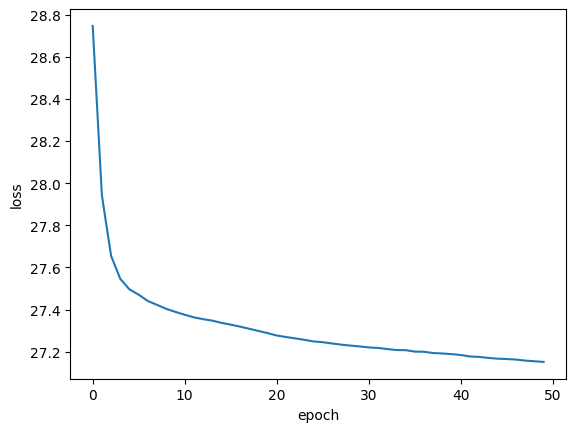

In [9]:
plt.plot(history.history['loss'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

In [10]:
batch_size = 500
feature_vectors = encoder.predict(x_data, batch_size=batch_size, verbose=1)
feature_vectors = keras.utils.normalize(feature_vectors)


I0000 00:00:1748259503.283933    1065 service.cc:152] XLA service 0x7fcdd002db70 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1748259503.284144    1065 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 3060, Compute Capability 8.6
2025-05-26 12:38:23.378605: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-05-26 12:38:24.846445: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1483_0', 108 bytes spill stores, 108 bytes spill loads

2025-05-26 12:38:24.918005: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1483', 4 bytes spill stores, 4 bytes spill loads

2025-05-26 12:38:24.970190: I ext

 13/120 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step

I0000 00:00:1748259508.572543    1065 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


120/120 ━━━━━━━━━━━━━━━━━━━━ 8s 15ms/step


In [11]:
knns = compute_knn(feature_vectors, batch_size=batch_size, kn=kn)


100%|██████████| 120/120 [00:07<00:00, 16.22it/s]


In [12]:
for layer in encoder.layers:
    layer.trainable = tune_encoder_during_clustering

clustering_model = create_clustering_model(encoder, num_clusters, input_shape, name='clustering')
clustering_learner = create_clustering_learner(clustering_model, input_shape)

losses = [ClustersEntropyLoss(), ClustersEntropyLoss(entropy_loss_weight=5)]

inputs = {"anchor": x_data, 'neighbours': tf.gather(x_data, knns)}
labels = [np.ones(shape=(x_data.shape[0], kn)), np.ones(shape=(x_data.shape[0], kn))]

clustering_learner.compile(
    optimizer=keras.optimizers.AdamW(learning_rate=0.0005, weight_decay=0.0001),
    loss=losses,
    jit_compile=False,
)

clustering_learner.fit(
    x=inputs,
    y=labels,
    batch_size=512,
    epochs=50
)



Epoch 1/50


2025-05-26 12:38:45.882872: W external/local_xla/xla/tsl/framework/bfc_allocator.cc:310] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.80GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


  1/118 ━━━━━━━━━━━━━━━━━━━━ 12:13 6s/step - clustering_loss: 0.0571 - loss: 1.0066 - simlarity_loss: 0.9496

2025-05-26 12:38:46.177260: W external/local_xla/xla/tsl/framework/bfc_allocator.cc:310] Allocator (GPU_0_bfc) ran out of memory trying to allocate 5.64GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2025-05-26 12:38:46.258487: W external/local_xla/xla/tsl/framework/bfc_allocator.cc:310] Allocator (GPU_0_bfc) ran out of memory trying to allocate 5.63GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


118/118 ━━━━━━━━━━━━━━━━━━━━ 22s 137ms/step - clustering_loss: 0.2238 - loss: 0.6263 - simlarity_loss: 0.4025
Epoch 2/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 19s 157ms/step - clustering_loss: 0.2925 - loss: 0.3603 - simlarity_loss: 0.0678
Epoch 3/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 16s 133ms/step - clustering_loss: 0.2796 - loss: 0.3436 - simlarity_loss: 0.0640
Epoch 4/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 19s 158ms/step - clustering_loss: 0.2782 - loss: 0.3353 - simlarity_loss: 0.0572
Epoch 5/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 16s 135ms/step - clustering_loss: 0.2753 - loss: 0.3283 - simlarity_loss: 0.0530
Epoch 6/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 19s 160ms/step - clustering_loss: 0.2721 - loss: 0.3272 - simlarity_loss: 0.0551
Epoch 7/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 16s 134ms/step - clustering_loss: 0.2755 - loss: 0.3232 - simlarity_loss: 0.0478
Epoch 8/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 19s 160ms/step - clustering_loss: 0.2779 - loss: 0.3199 - simlarity_loss: 0.0420
Epoch 9/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 16s

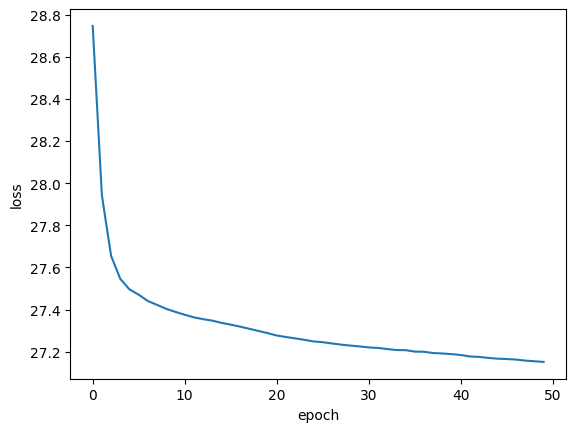

In [13]:
plt.plot(history.history["loss"])
plt.ylabel("loss")
plt.xlabel("epoch")
plt.show()


In [14]:
clustering_probabilitiys = clustering_model.predict(x_data, batch_size=batch_size)
cluster_assigment = keras.ops.argmax(clustering_probabilitiys, axis=-1).numpy()

cluster_confidence = keras.ops.max(clustering_probabilitiys, axis=-1).numpy()

120/120 ━━━━━━━━━━━━━━━━━━━━ 7s 24ms/step


In [15]:
from collections import defaultdict

clusters = defaultdict(list)

for idx, c in enumerate(cluster_assigment):
    clusters[c].append((idx, cluster_confidence[idx]))

non_empty_clusters = defaultdict(list)

for c in clusters.keys():
    if clusters[c]:
        non_empty_clusters[c] = clusters[c]

for c in range(num_clusters):
    print(f"Cluster {c}:  {len(clusters[c])}")

Cluster 0:  1669
Cluster 1:  2277
Cluster 2:  1488
Cluster 3:  2005
Cluster 4:  1752
Cluster 5:  1997
Cluster 6:  911
Cluster 7:  1263
Cluster 8:  439
Cluster 9:  1767
Cluster 10:  14454
Cluster 11:  999
Cluster 12:  2504
Cluster 13:  1900
Cluster 14:  2133
Cluster 15:  1693
Cluster 16:  1789
Cluster 17:  2530
Cluster 18:  1499
Cluster 19:  1436
Cluster 20:  1219
Cluster 21:  2268
Cluster 22:  2347
Cluster 23:  1685
Cluster 24:  1027
Cluster 25:  2622
Cluster 26:  1058
Cluster 27:  1269


In [16]:
from sklearn.neighbors import NearestNeighbors

k = 5
cluster_knns = {}

for c, members in non_empty_clusters.items():
    indices = [idx for idx, _ in members]
    if len(indices) < k + 1:

        continue

    clutser_features = feature_vectors[indices]
    nbrs = NearestNeighbors(n_neighbors=k + 1, algorithm='auto').fit(clutser_features)

    distances, n_indices = nbrs.kneighbors(clutser_features)

    knns = [ [indices[n] for n in n[1:]] for n in n_indices]

    cluster_knns[c] = dict(zip(indices, knns))



In [17]:
type(cluster_knns)

dict

In [18]:
from scipy.sparse import lil_matrix, issparse, csr_matrix

num_nodes = feature_vectors.shape[0]
adjencency = lil_matrix((num_nodes, num_nodes))

for cluster in cluster_knns.values():
    for node_idx, knn_lisy in cluster.items():
        for neighbor in knn_lisy:
            adjencency[node_idx, neighbor] = 1
            adjencency[neighbor, node_idx] = 2

In [29]:
from scipy.sparse import csr_matrix, issparse

def graph_augmented(features, adjencency):
    if not issparse(adjencency):
        adj_aug = csr_matrix(adjencency)
    else:
        adj_aug = adjencency.copy()

    mask = np.random.rand(*adj_aug.shape) < 0.1
    mask_sparse = csr_matrix(mask)

    adj_aug = adj_aug.multiply(mask_sparse)

    feat_aug = features.copy()
    mask_features = np.random.rand(*feat_aug.shape) < 0.1
    feat_aug[~mask_features] = 0

    return adj_aug, feat_aug

In [30]:
generator = GraphDataGenerator(feature_vectors, adjencency, augmented_fn=graph_augmented)

In [31]:
feature_dims = feature_vectors.shape[0]
proj_dims = 64
output_dims = 64
hidden_dims = 128

encoder = create_gnn_encoder(feature_dims, hidden_dims, proj_dims)
projector = create_projector(proj_dims, output_dims)

model = SimSiamGNN(encoder, projector)


In [32]:
model.compile(
    optimizer=keras.optimizers.Adam(1e-3)
)

In [33]:
model.fit(generator, epochs=50)

MemoryError: Unable to allocate 26.8 GiB for an array with shape (60000, 60000) and data type float64